<a href="https://colab.research.google.com/github/CeciASanz/NLP/blob/main/Ejercicio%203/3b%20-%20Custom%20embedding%20con%20Gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if platform.system() == 'Windows':
    !curl https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%203/H_P_and_the%20Sorcerers_Stone.txt -o H_P_and_the%20Sorcerers_Stone.txt
else:
    !wget H_P_and_the%20Sorcerers_Stone.txt https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%203/H_P_and_the%20Sorcerers_Stone.txt


--2023-08-25 01:11:37--  http://h_p_and_the%20sorcerers_stone.txt/
Resolving h_p_and_the sorcerers_stone.txt (h_p_and_the sorcerers_stone.txt)... failed: Name or service not known.
wget: unable to resolve host address ‘h_p_and_the sorcerers_stone.txt’
--2023-08-25 01:11:37--  https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%203/H_P_and_the%20Sorcerers_Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456722 (446K) [text/plain]
Saving to: ‘H_P_and_the Sorcerers_Stone.txt’

H_P_and_the Sorcere 100%[===================>] 446.02K  --.-KB/s    in 0.01s   

2023-08-25 01:11:38 (33.1 MB/s) - ‘H_P_and_the Sorcerers_Stone.txt’ saved [456722/456722]

FINISHED --2023-08-25 01:11:38--
Total wall clock time: 0.2s
Downloaded: 1 files, 446K in 0.01s (

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('H_P_and_the Sorcerers_Stone.txt', sep='/n', header=None)
df.head()

<ipython-input-3-0c798be8271a>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('H_P_and_the Sorcerers_Stone.txt', sep='/n', header=None)


,0
0,Harry Potter and the Sorcerer’s Stone
1,By J.K. Rowling
2,CHAPTER ONE
3,The Boy Who Lived
4,"Mr. and Mrs. Dursley, of number four, Privet D..."


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3000


### 1 - Preprocesamiento

In [5]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [6]:
# Demos un vistazo
sentence_tokens[:2]

[['harry', 'potter', 'and', 'the', 'sorcerer’s', 'stone'],
 ['by', 'j', 'k', 'rowling']]

### 2 - Crear los vectores (word2vec)

In [7]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [8]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [9]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [10]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 3000


In [11]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv))

Cantidad de words distintas en el corpus: 1784


### 3 - Entrenar el modelo generador

In [12]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 770813.9375
Loss after epoch 1: 557863.9375
Loss after epoch 2: 518398.0
Loss after epoch 3: 476998.125
Loss after epoch 4: 441338.75
Loss after epoch 5: 438446.0
Loss after epoch 6: 434947.0
Loss after epoch 7: 432904.5
Loss after epoch 8: 411438.25
Loss after epoch 9: 402255.0
Loss after epoch 10: 398639.5
Loss after epoch 11: 397073.0
Loss after epoch 12: 394334.5
Loss after epoch 13: 392841.5
Loss after epoch 14: 390505.5
Loss after epoch 15: 387534.5
Loss after epoch 16: 387222.5
Loss after epoch 17: 384380.5
Loss after epoch 18: 383487.0
Loss after epoch 19: 370723.0


(1055498, 1619300)

### 4 - Ensayar

In [13]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["harry"], topn=10)

[('he', 0.6944339871406555),
 ('ron', 0.6777154207229614),
 ('eagerly', 0.6712502837181091),
 ('yell', 0.6676045656204224),
 ('finally', 0.6640855669975281),
 ('goblin', 0.655276358127594),
 ('excitedly', 0.6474297642707825),
 ('finnigan', 0.6440061330795288),
 ('together', 0.6428718566894531),
 ('everybody', 0.6422857046127319)]

In [21]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["ron"], topn=10)

[('anxiously', 0.7165364623069763),
 ('nervously', 0.69289630651474),
 ('“thanks', 0.6891520619392395),
 ('harry', 0.6777154803276062),
 ('excitedly', 0.6753511428833008),
 ('finally', 0.672845721244812),
 ('eagerly', 0.6642279028892517),
 ('“hagrid', 0.661038875579834),
 ('percy', 0.6595354080200195),
 ('miserably', 0.6556795239448547)]

In [22]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["hermione"], topn=10)

[('eagerly', 0.6431689262390137),
 ('excitedly', 0.6370903849601746),
 ('finally', 0.6200612187385559),
 ('“snape’s', 0.6160683035850525),
 ('ron', 0.6000311374664307),
 ('fang', 0.5993953943252563),
 ('cheer', 0.5969716310501099),
 ('harry', 0.5921779870986938),
 ('anxiously', 0.5921298861503601),
 ('dean', 0.5918468236923218)]

In [14]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["hagrid"], topn=10)

[('or', -0.0506947785615921),
 ('full', -0.05906566232442856),
 ('dark', -0.08370140939950943),
 ('made', -0.12167414277791977),
 ('my', -0.12480951100587845),
 ('by', -0.12577562034130096),
 ('with', -0.1309216022491455),
 ('common', -0.13498744368553162),
 ('cup', -0.14298312366008759),
 ('in', -0.15101204812526703)]

In [23]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["dumbledore"], topn=10)

[('“sorry', 0.7012707591056824),
 ('mcgonagall', 0.6963121294975281),
 ('quirrell', 0.6865072250366211),
 ('flitwick', 0.6752884387969971),
 ('“everyone', 0.6594535112380981),
 ('mcgonagall’s', 0.6557175517082214),
 ('“yeah', 0.6502814888954163),
 ('“welcome', 0.6490548253059387),
 ('joking', 0.6487786173820496),
 ('voldemort', 0.648356556892395)]

In [24]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["alley"], topn=5)

[('diagon', 0.9381645917892456),
 ('safely', 0.8960221409797668),
 ('herself', 0.8823679685592651),
 ('road', 0.867967963218689),
 ('scrambled', 0.8678065538406372)]

### 5 - Visualizar agrupación de vectores

In [17]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model):
    num_dimensions = 2

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [18]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

### Alumno

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

### Cambios realizados


*   Se utilizo como texto a analizar el libro Harry Potter and th Sorcerer's Stone.
*   Se analizaron distintos terminos relacionados con el libro.


### Conclusiones

*  Al buscar las palabras relacionadas con "alley" (callejón) devuelve como mas relacionada "diagon" que es el nombre del callejón en el libro.
*  Al buscar las palabras relacionadas con los nombres de los personajes principales (Harry Ron, Hermione) aparecen los nombres de los otros. Esto también se puede ver reflejado en la representación gráfica.

  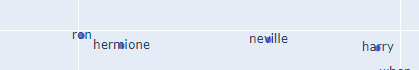
*   En la representacion grafica tambien se puede ver que cerca de la palabra "professor" se encuentran los nombres de los profesores de la escuela.

  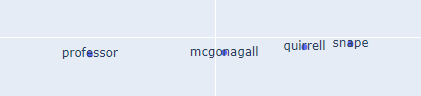

